In [1]:
import sqlite3
import pandas as pd
import matplotlib.dates as dates
from datetime import datetime as dt
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

import Cdf

In [2]:
params = {'axes.labelsize' : 14, 'axes.titlesize' : 14,
          'font.size' : 14, 'legend.fontsize' : 14,
          'xtick.labelsize' : 14, 'ytick.labelsize' : 14}
plt.rcParams.update(params)

In [3]:
conn = sqlite3.connect('../data/netflix-data-aggregated.db')
netflix = pd.read_sql_query('select * from netflix', con=conn, parse_dates=['dtime'])
conn.close()

In [4]:
labels = ['delta_bytes_sec', 'bytes_sec_v4', 'bytes_sec_v6']

for label in labels:
    netflix[label] = netflix[label]/1024.0/1024.0

In [5]:
netflix['dtime'] = netflix['dtime'].dt.floor('D')

In [6]:
df = netflix.groupby(['unit_id', 'dtime'], as_index=False
                    ).agg({'delta_bytes_sec' : 'median',
                           'bytes_sec_v4' : 'median',
                           'bytes_sec_v6' : 'median'}
                         )
df

,unit_id,dtime,delta_bytes_sec,bytes_sec_v4,bytes_sec_v6
0,62712,2017-01-31,-1.139467,3.912182,5.053080
1,62712,2017-02-01,-1.488352,2.595761,4.268476
2,62712,2017-02-02,-1.154538,3.899891,4.981090
3,62712,2017-02-03,-1.142268,3.894275,5.051538
4,62712,2017-02-04,-1.238555,3.893835,5.082806
...,...,...,...,...,...
48839,950240,2017-08-08,0.042439,2.961061,2.918577
48840,950240,2017-08-09,0.042429,2.961078,2.918470
48841,950240,2017-08-10,0.042513,2.960479,2.917936
48842,950240,2017-08-11,0.042638,2.960185,2.917544


In [7]:
df['year'] = df['dtime'].dt.year
df['month'] = df['dtime'].dt.month

In [8]:
by_years = df.groupby('year')

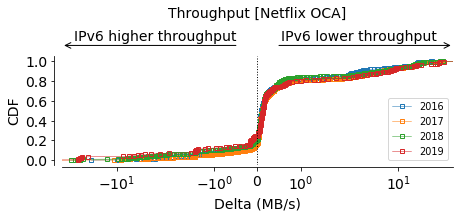

In [9]:
cdf_fig, cdf_ax = plt.subplots(figsize = (7, 2))

cdfs = []

for year, year_df in by_years:
    throughput = Cdf.MakeCdfFromList(year_df['delta_bytes_sec'])

    cdf_ax.plot(throughput.xs, throughput.ps, label = year, marker = 's',
                linewidth = 0.5, markersize = 3.5, fillstyle = 'none',
                markevery=15)

    cdfs.append((year, 'Throughput Deltas', throughput))

cdf_ax.set_ylim([-0.05, 1.05])
cdf_ax.set_xlabel('Delta (MB/s)')
cdf_ax.set_ylabel('CDF')
cdf_ax.set_xlim([-50, 50])
cdf_ax.set_xscale('symlog')

cdf_ax.legend(loc = 'lower right', fontsize = 'x-small')

yticks = np.arange(0.0, 1.01, 0.2)
cdf_ax.set_yticks(yticks)
cdf_ax.grid(False)
cdf_ax.spines['right'].set_color('none')
cdf_ax.spines['top'].set_color('none')
cdf_ax.yaxis.set_ticks_position('left')
cdf_ax.xaxis.set_ticks_position('bottom')
cdf_ax.spines['bottom'].set_position(('axes', -0.02))
cdf_ax.spines['left'].set_position(('axes', -0.02))

cdf_ax.set_title('Throughput [Netflix OCA]', y=1.3)

cdf_ax.axvline(x=0.0, linewidth=1.0, color='black', ls = 'dotted')

cdf_ax.annotate('', xy = (0.45, 1.1), xycoords = 'axes fraction', xytext = (0, 1.1), 
            arrowprops = dict(arrowstyle = "<-"))
cdf_ax.annotate('', xy = (1, 1.1), xycoords = 'axes fraction', xytext = (0.55, 1.1), 
                    arrowprops = dict(arrowstyle="->"))

cdf_ax.text(0.03, 1.15, "IPv6 higher throughput", transform=cdf_ax.transAxes)
cdf_ax.text(0.56, 1.15, "IPv6 lower throughput", transform=cdf_ax.transAxes)


cdf_fig.savefig('../plots/netflix-delta-throughput-by-year.pdf', bbox_inches = 'tight')
plt.show()

In [10]:
for year, version, cdf in cdfs:
    print(year, '\t\t', version)
    print('----------------')
    skip = int(len(cdf.xs)/150)
    for x, p in list(zip(cdf.xs, cdf.ps))[::skip]:
        print('%.2f\t\t%.5f' % (x, p))
    print('\n===========================\n')

2016 		 Throughput Deltas
----------------
-21.06		0.00012
-8.43		0.00663
-4.29		0.01315
-2.94		0.01967
-2.66		0.02618
-2.20		0.03270
-1.72		0.03922
-1.49		0.04573
-1.45		0.05225
-1.36		0.05877
-1.16		0.06529
-0.97		0.07180
-0.79		0.07832
-0.70		0.08484
-0.61		0.09135
-0.52		0.09787
-0.43		0.10439
-0.35		0.11090
-0.28		0.11742
-0.23		0.12394
-0.18		0.13046
-0.14		0.13697
-0.11		0.14349
-0.08		0.15001
-0.05		0.15652
-0.04		0.16304
-0.02		0.16956
-0.01		0.17607
-0.00		0.18259
0.00		0.18911
0.01		0.19586
0.01		0.20237
0.01		0.20889
0.01		0.21552
0.02		0.22227
0.02		0.22914
0.03		0.23566
0.03		0.24217
0.03		0.24869
0.03		0.25544
0.03		0.26231
0.03		0.26917
0.03		0.27569
0.04		0.28221
0.04		0.28884
0.04		0.29547
0.04		0.30246
0.04		0.30909
0.04		0.31572
0.04		0.32224
0.05		0.32887
0.05		0.33539
0.05		0.34202
0.05		0.34901
0.05		0.35692
0.05		0.36413
0.05		0.37077
0.05		0.37728
0.05		0.38380
0.06		0.39032
0.06		0.39695
0.06		0.40347
0.06		0.41010
0.06		0.41662
0.06		0.42337
0.06		0.42988
0.0

In [11]:
for year, year_df in by_years:
    print(year,'\n==================')
    print(
        year_df[['bytes_sec_v4', 'bytes_sec_v6']
               ].describe().iloc[-2])
    print('==================\n')

2016 
bytes_sec_v4    10.580163
bytes_sec_v6    10.323678
Name: 75%, dtype: float64

2017 
bytes_sec_v4    11.170921
bytes_sec_v6    10.854432
Name: 75%, dtype: float64

2018 
bytes_sec_v4    13.311109
bytes_sec_v6    11.066157
Name: 75%, dtype: float64

2019 
bytes_sec_v4    12.043904
bytes_sec_v6    12.215167
Name: 75%, dtype: float64



In [12]:
for year, year_df in by_years:
    print(year,'\n==================')
    print(
        year_df[['delta_bytes_sec']
               ].describe().iloc[-2])
    print('==================\n\n')

2016 
delta_bytes_sec    0.441247
Name: 75%, dtype: float64


2017 
delta_bytes_sec    0.496942
Name: 75%, dtype: float64


2018 
delta_bytes_sec    0.43654
Name: 75%, dtype: float64


2019 
delta_bytes_sec    0.582234
Name: 75%, dtype: float64


